# Assignment 5: Neuroevolution

**Goal**: Implement an Evolutionary Algorithm to optimize an Artificial Neural Network (ANN) based controller for the CartPole task in OpenAI Gym environment.

CartPole evaluation environment functions are provided. Your goal is to implement your ANN to control the cartpole and use your Evolutionary Algorithm to optimize the ANN parameters (weights).

Please answer the `Questions` and implement coding `Tasks` by filling **PLEASE FILL IN** sections. *Documentation* of your code is also important. You can find the grading scheme in implementation cells.

  * Plagiarism is automatically checked and set to **0 points**

  * It is allowed to learn from external resources but copying is not allowed. If you use any external resource, please cite them in the comments (e.g. `# source: https://...../` (see `fitness_function`))

**Install Prerequisites**

In [37]:
# Run this cell to install the required libraries
%pip install numpy matplotlib scipy
%pip install moviepy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


**Imports**

In [3]:
# Necessary libraries
import matplotlib.pyplot as plt
import numpy as np

%pip install keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [50]:
%pip install tensorflow
%pip install deap
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from deap import base, creator, tools, algorithms

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Enables inline matplotib graphs
%matplotlib inline
# Comment the line above and uncomment the lines below to have interactive plots
# WARN: may cause dependency issues
#%matplotlib qt5
#%pip install PyQt5
#plt.ion()

In [7]:
%pip install gymnasium
import gymnasium as gym

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


---
**Question 1 (0-0.25-0.5 pt):** Following link provides more information about the CartPole environemnt we would like to find an ANN to control: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

Please have a look at the link and note the observation and action spaces, how many dimensions they have? Are they continous or discrete, and what kinds of value they can get?

**Answer:** From what I can deduce from that website, the observation space is a four-dimensional vector containing information about the cart's position, velocity, pole angle, and pole angular velocity. The action space is discrete and it has only 2 possibilities, which are pushing the cart left or right.


---
**Question 2 (0-0.25-0.5 pt):** What is your proposed ANN architecture and why? Please also discuss the activation functions you choose.

**Answer:** My proposed ANN architecture would be an input layer with 4 neurons corresponding to the 4 dimensions of the observation space, 1-2 hidden layers with a no. of neurons each. I would like to determine the exact number after experimentation, and an output layer with 2 neurons, depicting the 2 possible actions. For the hidden layers, the Rectified Linear Unit function is a common choice, which is what I will choose. For the output layer, i will use the softmax function. 

---
**Task 1: Implementation of Evolutionary Algrotihm (0-1.6-3.8-4.2-5 pt):** Implement your evolutionary algorithm to find an ANN controller for the CartPole task.

In [184]:
#################################
# Grading
# 0 pts if the code does not work, code works but it is fundamentally incorrect
# 1.6 pts if the code works but some functions are incorrect and it is badly explained
# 3.8 pts if the code works but some functions are incorrect but it is explained well
# 4.2 pts if the code works very well aligned with the task without any mistakes, but it is badly explained
# 5 pts if the code works very well aligned with the task without any mistakes, and it is well explained
################################################################


# Artificial Neural Network parameters (weights)
# See here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/ for input and output space
# PLEASE SPECIFY BELOW
input_neurons = 4
hidden_neurons = 10
output_neurons = 2

# Create the OpenAI gym environment
environment = gym.make("CartPole-v1")

class SimpleEnvironment: # Simple environment for testing purposes
    def __init__(self, target_position=10): # Target position is the position the agent needs to reach
        self.position = 0
        self.target_position = target_position # Target position

    def reset(self): # Reset the environment
        self.position = 0 # Reset the position
        return np.array([self.position]) # Return the initial observation

    def step(self, action):
        if action == 0:
            self.position -= 1  # move left
        else:
            self.position += 1  # move right

        done = self.position == self.target_position # Check if the agent has reached the target position
        reward = 1 if done else -1 # Reward is 1 if the agent has reached the target position, -1 otherwise

        return np.array([self.position]), reward, done, {} # Return the observation, reward, done flag and info

def evaluate_cartpole(individual):
    observation, info = environment.reset(seed = 0) # Reset the environment

    total_reward = 0
    step_count = 0
    done = False
    max_steps = 1000

    for step_count in range(max_steps): # Loop until the maximum number of steps is reached
        w1 = np.array(individual[:input_neurons*hidden_neurons]).reshape((input_neurons, hidden_neurons)) # Weights for the first layer
        w2 = np.array(individual[input_neurons*hidden_neurons:]).reshape((hidden_neurons, output_neurons)) # Weights for the second layer

        hidden_layer = np.tanh(np.dot(observation, w1)) # Hidden layer
        output_layer = np.dot(hidden_layer, w2) # Output layer
        action = np.argmax(output_layer) # Choose the action with the highest output

        observation, reward, done, tr, info = environment.step(action) # Take a step in the environment
        total_reward += reward # Increment the total reward

        if done: # If the episode is done
            break # Exit the loop

    environment.close() # Close the environment
    return min(max_steps, total_reward)

def initialize_population(population_size, num_dimensions):
    lower_bound = -2 # Lower bound for the random numbers
    upper_bound = 2 # Upper bound for the random numbers

    population = np.random.uniform(lower_bound, upper_bound, (population_size, num_dimensions)) # Generate a random population

    return population

def evaluate_population(population, objective_function):
    fitness_scores = [] # List to store the fitness scores

    for individual in population:
        fitness = objective_function(individual) # Evaluate the individual
        fitness_scores.append(fitness) # Append the fitness score to the list

    fitness_scores = np.array(fitness_scores) # Convert the list to a numpy array

    return fitness_scores

def perform_crossover(parents, crossover_probability):
    offspring = []
    i = 0
    while i < len(parents): # Loop through the parents
        if np.random.rand() < crossover_probability: # Check if the crossover should be performed
            crossover_point = np.random.randint(0, len(parents[i])) # Choose a random crossover point
            offspring.append(np.concatenate((parents[i][:crossover_point], parents[(i+1)][crossover_point:]))) # Perform the crossover
            offspring.append(np.concatenate((parents[i][crossover_point:], parents[(i+1)][:crossover_point])))
        else:
            offspring.append(parents[i]) # Append the parents to the offspring
            offspring.append(parents[i+1])
        i += 2

    return offspring

def perform_mutation(population, mutation_rate):
    i = 0 # Initialize the counter
    while i < len(population): # Loop through the population
        if np.random.rand() < mutation_rate: # Check if the mutation should be performed
            mutation_index = np.random.randint(0, len(population[i])) # Choose a random mutation index
            population[i][mutation_index] = np.random.uniform(-1, 1) # Perform the mutation
        i += 1 # Increment the counter
    return population

def select_parents(population, fitness):
    sorted_indices = np.argsort(fitness) # Sort the fitness scores
    return [population[i] for i in sorted_indices[:10]], [fitness[i] for i in sorted_indices[:10]] # Return the top 10 individuals

def select_survivors(population, fitness, offspring, offspring_fitness):
    population = np.concatenate((population, offspring)) # Concatenate the population and offspring
    fitness = np.concatenate((fitness, offspring_fitness)) # Concatenate the fitness scores
    sorted_indices = np.argsort(fitness)[::-1] # Sort the fitness scores in descending order
    return population[sorted_indices][:len(population)], fitness[sorted_indices][:len(fitness)] # Return the top individuals

def evolutionary_algorithm(population_size, max_fitness_evaluations, crossover_probability, mutation_rate, objective_function):
    dimensions = input_neurons * hidden_neurons + hidden_neurons * output_neurons # Calculate the number of dimensions

    max_generations = int(max_fitness_evaluations / population_size) # Calculate the maximum number of generations
    population = initialize_population(population_size, dimensions) # Initialize the population
    fitness = evaluate_population(population, objective_function) # Evaluate the population

    best_individual_index = np.argmax(fitness) # Find the index of the best individual
    best_individuals = [population[best_individual_index]] # List to store the best individuals
    best_fitness = [fitness[best_individual_index]] # List to store the best fitness scores

    generation = 0
    while generation < max_generations - 1: # Loop through the generations
        parents, parents_fitness = select_parents(population, fitness) # Select the parents
        offspring = perform_crossover(parents, crossover_probability) # Perform the crossover
        offspring = perform_mutation(offspring, mutation_rate) # Perform the mutation
        offspring_fitness = evaluate_population(offspring, objective_function) # Evaluate the offspring

        population, fitness = select_survivors(population, fitness, offspring, offspring_fitness) # Select the survivors

        best_individual_index = np.argmax(fitness) # Find the index of the best individual
        if fitness[best_individual_index] > best_fitness[-1]:
            best_individuals.append(population[best_individual_index]) # Append the best individual to the list
            best_fitness.append(fitness[best_individual_index]) # Append the best fitness score to the list
        else:
            best_individuals.append(best_individuals[-1]) # Append the previous best individual to the list
            best_fitness.append(best_fitness[-1]) # Append the previous best fitness score to the list
        generation += 1

    return best_individuals, best_fitness

#### Check Your Implementation: Running The Evolutionary Algorithm

Run the cell below, if you implemented everything correctly, you should see the algorithm running. Furthermore,

In [185]:
kwargs = {
    "population_size": 20,
    "max_fitness_evaluations": 1000,  # maximum number of fitness evaluations
    "crossover_probability": 0.9,  # crossover probability
    "mutation_rate": 0.1,  # mutation rate
    "objective_function": evaluate_cartpole,
}

# Run your algorithm once and find the best ANN weights found
x_best, f_best = evolutionary_algorithm(**kwargs)

# Print the best ANN weights found and best fitness
print("Best ANN parameters found:", x_best[-1])
print("Best fitness found:", f_best[-1])

# Evaluate your ANN weights again
if f_best[-1] >= 1000:
    print("The best fitness 1000 was found!")
else:
    print("The best fitness 1000 was not found, try again!!")

Best ANN parameters found: [ 0.08283728 -0.79256556 -1.40881678 -0.3503358  -0.02545031 -1.39212336
 -0.15077187 -1.35668144 -0.86008792 -1.09818364  0.27897969 -1.67336635
 -0.06625724 -0.90635417  1.30594192  1.30588321  1.43882792  0.98569875
 -0.12656481 -1.47591832  1.46471963 -1.42066149 -0.66992878 -0.02531165
  1.56758315 -1.87935178 -0.39892071 -1.40317306  1.59643505  0.96912162
  1.56040833  1.1232672   0.82242958  0.74593328 -0.25792858 -1.41896757
 -1.08903368 -0.46105097 -0.14014045  0.41291675 -0.9706581   0.7812752
  1.70485353 -1.61066525  0.72648937  1.79151494  0.1804119  -1.53525396
 -0.10232364  1.53961965 -0.53022991 -1.81537345  1.13741167 -0.08692545
 -0.20422096 -1.9830867  -1.38729032  0.42743139 -1.97751213 -1.51359841]
Best fitness found: 1000.0
The best fitness 1000 was found!


---
**Question 3 (0-0.25-0.5 pt):** Please comment on the behavior of the final solution. Were you able to find the best solution (i.e. ANN weights which achieves best fitness: 1000) and was it possible to controll the CartPole task without letting the the pole fall?

**Answer:** The Algorithm successfully found the besst solution which achieved the fitness score of 1000. Thus, the ANN was able to control the CartPole task without letting the pole fall. The best weight found represents the best answer for the given parameters and objective function. 

**Average results of your algorithm**

Remember that the EAs are sthocastic algorithms that can produce different results as a result of independent runs.

Therefore, we would like to see the average results and standard deviations.


---
**Task 2 (0-1.5-3 pt):** Please run your algorithm for at least 10 times and plot the average results and standard deviations. Below, you may add as many cells as you need for this implementation and plot functions. You may use previous code you have developed/used during the course.

In [186]:
def calculate_mean_std(f_best):
    """This is a helper function to calculate the mean and standard deviation of the best fitness values."""
    max_length = max(len(lst) for lst in f_best) # Find the length of the longest list
    padded_lists = [] # Create an empty list to store the padded lists
    for lst in f_best: 
        padded_list = lst + [np.nan] * (max_length - len(lst)) # Pad the lists with np.nan values
        padded_lists.append(padded_list) # Append the padded lists to the list of padded lists

    f_best = np.array(padded_lists) # Convert the list of padded lists to a numpy array

    avg = np.nanmean(f_best, axis=0) # Calculate the mean of the best fitness values
    std = np.nanstd(f_best, axis=0) # Calculate the standard deviation of the best fitness values

    return avg, std

In [188]:
def run_experiment(population_size, p_crossover, m_rate):
    runs = 10  # DO NOT CHANGE - number of runs
    max_fit_evals = 5000 # DO NOT CHANGE - maximum number of fitness evaluations

    fitness_result = [] # List to store the best fitness values for the fitness_result function


    run = 0 # Initialize the run counter
    while run < runs: # Loop through the runs
        _, best_fitness = evolutionary_algorithm( # Run the evolutionary algorithm
            population_size[0], # Population size
            max_fit_evals, # Maximum number of fitness evaluations
            p_crossover[0], # Crossover probability
            m_rate[0], # Mutation rate
            evaluate_cartpole, # Objective function
        )
        run += 1 # Increment the run counter
        fitness_result.append(best_fitness) # Append the best fitness values to the list

    avg_fitness, std_fitness = calculate_mean_std(fitness_result) # Calculate the mean and standard deviation of the best fitness values

    avgs = [avg_fitness] # List to store the average fitness values
    stds = [std_fitness] # List to store the standard deviation of the fitness values
    all_runs = [fitness_result] # List to store the best fitness values for each run

    return avgs, stds, all_runs # Return the average fitness values, standard deviation of the fitness values, and the best fitness values for each run

In [189]:
def generate_subplot_function(avgs_exp_1,stds_exp_1,labels,avgs_exp_2,stds_exp_2,n_cols,n_queens):
    """This helper function generates subplots for the experiments."""
    fig, axes = plt.subplots(figsize=(13, 9)) # Create a figure and axes
    idx = 0 # Initialize the counter
    while idx < len(avgs_exp_1): # Loop through the number of subplots
        axes.plot(avgs_exp_1[idx], label="Experiment 1", color="blue") # Plot the average fitness values for experiment 1
        axes.fill_between(np.arange(len(avgs_exp_1[idx])),avgs_exp_1[idx] - stds_exp_1[idx],avgs_exp_1[idx] + stds_exp_1[idx],alpha=0.2,color="blue",) # Fill the area between the average fitness values and the standard deviation
        axes.set_title(labels[idx]) # Set the title of the subplot
        axes.set_ylim(bottom=0) # Set the lower limit of the y-axis
        if n_queens: # Check if the number of queens is specified
            axes.set_ylim(top=n_queens[idx]) # Set the upper limit of the y-axis

        idx += 1
    axes.set_xlabel("Generations") # Set the x-axis label
    axes.set_ylabel("Avg Best Fitness") #  Set the y-axis label
    axes.legend() # Add a legend to the plot

    plt.tight_layout()

In [190]:
population_size = [50]  # DO NOT CHANGE
p_crossover = [0.9]  # DO NOT CHANGE
m_rate = [0.5]  # DO NOT CHANGE

avgs_exp_1, stds_exp_1, all_runs_experiment_1 = run_experiment(
    population_size, p_crossover, m_rate
)

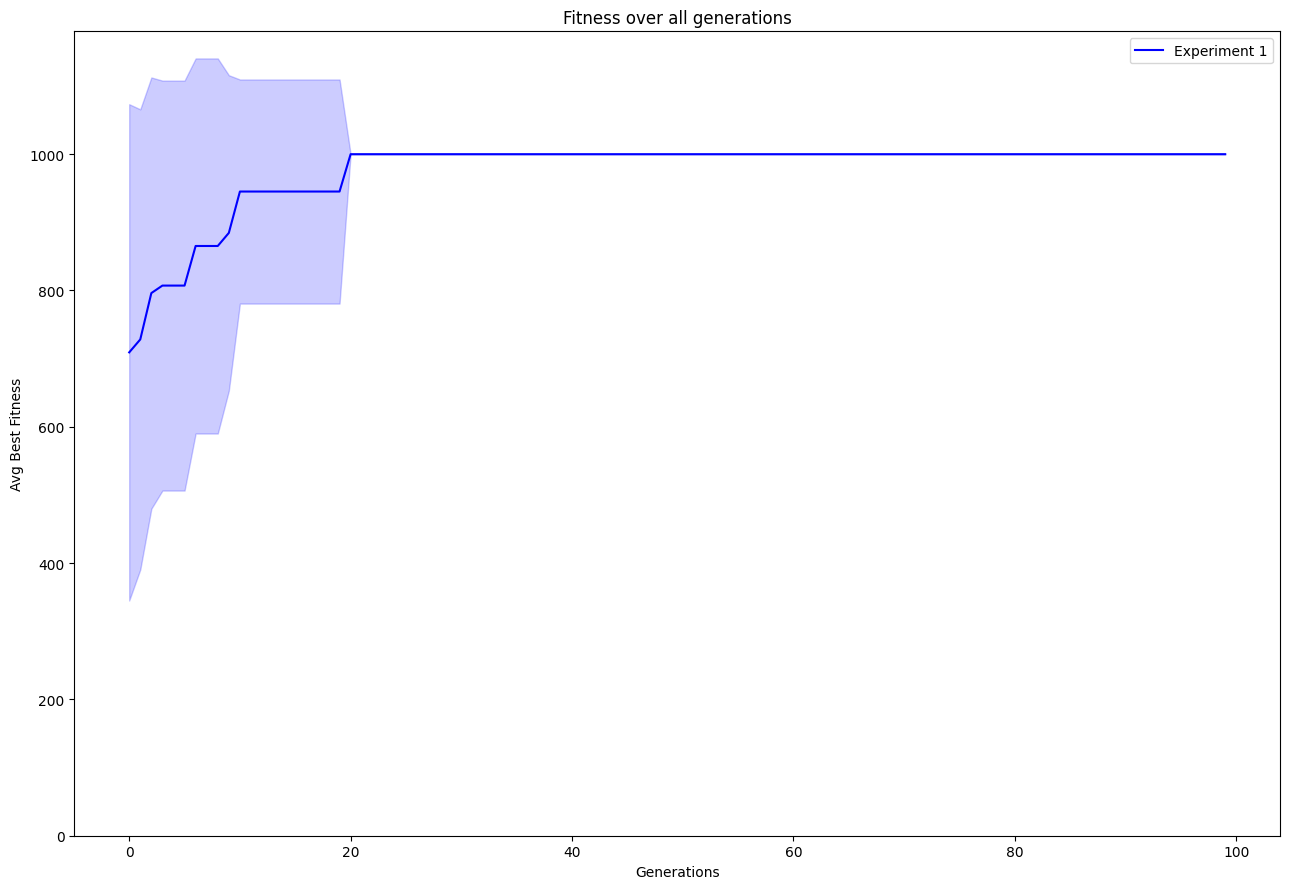

In [192]:
labels = [  # DO NOT CHANGE
    "Fitness over all generations",
]

generate_subplot_function(
    avgs_exp_1,
    stds_exp_1,
    labels,
    avgs_exp_2=None,
    stds_exp_2=None,
    n_cols=2,
    n_queens=None,
)

---
**Question 4 (0-0.25-0.5 pt):** Please comment on the average behavior of your algorithm. How did the average results and standard deviations look? Did your algorithm converge all the time to the best fitness?

**Answer:** On average, my algorithm performs really well. It starts from a certain point and continuously climbs upwards until it reaches the best fitness of 1000. After getting to the best fitness (1000), it stays there as it should. The average fitness of the population increased over time with the algorithm progressing, which indicates that the algoirthm is exploring the solution space and finding increasinly better solutions.